# Co trzeba omówić

- Co to jest sygnał?
- Jak się ma sygnał do odwzorowania rzeczywistości?
- Jak można podzielić sygnały i dlaczego to jest ważne?
- Czym się różni sygnał analogowy od dyskretnego?
- Jak zamienić sygnał analogowy na dyskretny?
 - Co to jest próbkowanie?
 - Twierdzenie o próbkowaniu
 - Jak wygląda undersampling w praktyce? (skrypt)
 - Co to jest kwantyzacja?
 - ADC i DAC
 - Zastosowania
   - Sampling sygnału audio
- Co to jest filtr?
 - to bardzo krótko i bardzo ogólnie
- Jakie informacje można wyciągnąć z sygnału?
 - Podstawowe rzeczy - wartości itd.
 - Krótko o autokorelacji
 - Co to jest analiza częstotliwościowa?
   - Jak zamienić sygnał z dziedziny czasu na częstotliwości?
   - Bardzo ogólnie: matematyczne podstawy transformaty Fouriera
   - Odwrotna transformata Fouriera: zamiana sygnału z dziedziny częstotliwości na dziedzinę czasu
   - Jak czytać charakterystykę częstotliwościową: fajne obrazki
     - Na podstawie fajnych obrazków i radia omówić modulację: AM, FM - i tylko na nich
   - Jak przyspieszyć obliczenia używając FFT
   - Zastosowania
     - OFDM
- Omówić pokrótce falki jako uogólnienie Fouriera
- Zastosowania, których nie wymieniliśmy wyżej, a są fajne
  - Rozmycie Gaussowskie
  - Efekty gitarowe jako filtry
  - Szybki tutorial jak zostać youtuberem i zarabiać na przesterach
  - Jak działa WiFi?
  - Sygnał EKG
  - Czy coś jeszcze?

# Warsztaty sygnałów

**Jak można przeanalizować sygnał?**
  - wyciągnąć podstawowe informacje - amplituda, rodzaj sygnału
  - sprawdzić, jaki zakres częstotliwości zajmują
      - analiza częstotliwościowa sygnału
      - analiza widmowa sygnału
  - obliczyć moc
  - sprawdzić, czy sygnał ma tendencję do powtarzania się w czasie (autokorelacja)
  - i wiele innych

# Warsztaty sygnałów

**Jak można przekształcać sygnały?**
  - filtrowanie sygnału
  - (de)modulacja
  - podstawowe operacje na funkcjach: np. przesunięcia, symetrie
  - i wiele innych

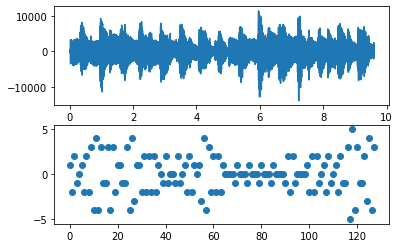

In [10]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

sample_rate, data = wavfile.read('./NONFREE/Carefree.wav')

dt = 1/sample_rate
length_in_s = len(data) * dt
t = np.arange(0, length_in_s, dt)
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(t[0:len(data)], data)
n_samples = 128
ax1.plot(range(n_samples), data[0:n_samples], 'o')
#ax1.psd(s, 512, 1 / dt)

In [11]:
plt.show()

# TODO: enlarge plot

Co możemy powiedzieć o tym sygnale:
- jest to sygnał cyfrowy (dyskretny czas, dyskretne wartości)
- zależy od czasu
- ma pewną widoczną okresowość
- intuicyjnie: pewnie ma skończoną moc

In [12]:
# Dla przykładu analizy sygnału weźmiemy sobie próbkę audio
# utworu, który wszyscy znają

from playsound import playsound
#"Carefree"
#Kevin MacLeod (incompetech.com)
#Licensed under Creative Commons: By Attribution 3.0
#http://creativecommons.org/licenses/by/3.0/
playsound('./NONFREE/Carefree.wav')

In [14]:
import random
random.seed()

max_sample = max(data)
min_sample = min(data)
sample_codes_count = len(set(data))

# UWAGA: to jest wartość średnia sygnału w przedziale,
# nie całego - sygnał jest traktowany jako skończony
# Będzie to widoczne zwłaszcza przy analizie częstotliwościowej!
def discrete_signal_average(data):
    values_sum = sum(data)
    sample_count = len(data) + 1
    return values_sum / sample_count

def discrete_signal_energy(data):
    values_squared = [x^2 for x in data]
    return sum(values_squared)

def discrete_average_power(data):
    values_squared = [x^2 for x in data]
    return discrete_signal_average(values_squared)

print(f"Liczba wartości sygnału: {sample_codes_count} - z przedziału [{min_sample}; {max_sample}]")
random_sample = random.randint(0, len(data))
print(f"Losowo wybrana próbka {random_sample} ma wartość {data[random_sample]}")
print(f"Wartość średnia sygnału: {discrete_signal_average(data)}, energia sygnału: {discrete_signal_energy(data)},",
       f"średnia moc sygnału: {discrete_average_power(data)}")

Liczba wartości sygnału: 14403 - z przedziału [-13929; 11504]
Losowo wybrana próbka 160118 ma wartość -136
Wartość średnia sygnału: 0.22847246652610503, energia sygnału: 96955, średnia moc sygnału: 0.2289163453660702


# Analiza częstotliwościowa

**Częstotliwość** - powtarzalność zjawiska w określonej jednostce czasu

Sporo sygnałów:
- określonych jest w dziedzinie czasu: **f(t)**
- ma komponenty powtarzające się z określoną częstotliwością

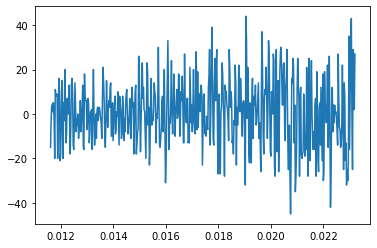

In [16]:
fig2, ax = plt.subplots()
ax.plot(t[512:1024], data[512:1024])
plt.show()

# Rozwiązanie - funkcje trygonometryczne!

- sin(x) - ma częstotliwość 1 Hz
- sin(2x) - częstotliwość 2 Hz
- sin(nx) - częstotliwość n Hz

**Gdyby tylko dało się wyrazić naszą funkcję za pomocą sumy wielu sinusów!**

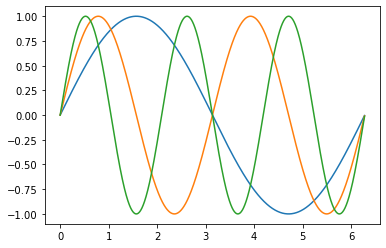

In [22]:
sintime = np.arange(0, 2*np.pi, np.pi/720)
def gen_sin(data, freq):
    return [np.sin(x * freq) for x in data]

fig3, ax = plt.subplots()
ax.plot(sintime, gen_sin(sintime, 1))
ax.plot(sintime, gen_sin(sintime, 2))
ax.plot(sintime, gen_sin(sintime, 3))
plt.show()

# Bardzo szybko: teoria transformaty Fouriera
## Przestrzeń liniowa
**Przestrzeń liniowa** - abstrakcyjny zbiór elementów ze zdefiniowanymi podstawowymi operacjami: dodawanie i mnożenie przez skalar.

Elementy w przestrzeni liniowej wyraża się poprzez dodawanie i mnożenie pewnej **bazy**

**Czy możemy zrobić przestrzeń liniową, w której bazą będzie nieskończony zbiór funkcji typu sin(x), sin(2x), ...?**

## Twierdzenie Eulera-Fouriera

**Tak!**

**W bardzo dużym skrócie** szereg sinusów i cosinusów wyrażony wzorem sin(nx):
- jest liniowo niezależny (ortogonalny - żaden z elementów nie może zostać wyrażony w postaci istniejących elementów)
- jest maksymalnie uproszczony (ortonormalny)
- z wzoru Eulera-Fouriera, przy założeniu odpowiednich współczynników, może posłużyć do zbudowania szeregu zbieżnego do niej

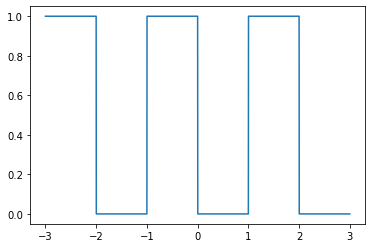

In [29]:
time_simplesig = np.arange(-3, 3, 0.001)
pwm_simplesig = [1 * int(x%2) for x in time_simplesig]

# TODO: rewise and get it to work
def expand_dft(data, function_no, function_out):
    dft_out = [0 for x in range(len(data))]
#    for n in dft_out:
#        n = 
    
    return sum(dft_out)

fig4, ax = plt.subplots()
ax.plot(time_simplesig, pwm_simplesig)


**Tutaj przykłady transformacji Fouriera**

# Idźmy dalej...

**dyskretna transformata Fouriera**

# Złożoność obliczeniowa

**FFT - Cooley-Tukey**

# Własności transformaty Fouriera

**TODO**
- splot -> mnożenie
- odwrotna transformata Fouriera

# Bibliografia

- prof. Tadeusz. Zieliński, ''Cyfrowe Przetwarzanie Sygnałów - Od Teorii do Zastosowań''
- prof. Jerzy Szabatin, ''Przetwarzanie Sygnałów''
- R. K. Rao Yarlagadda, ''Analog and Digital Signals and Systems''
- Richard G. Lyons, ''Understanding Digital Signal Processing''
- dr Kinga McInerney, ''Fourier Series for Electronics and Telecommunications''
- dr Kinga McInerney, ''Fourier Transform for Electronics and Telecommunications''
- Theodore Rappaport, ''Wireless Communications Principles and Practice''